# 0. Configuration

In [1]:
# links to shared data MovieLens
# source on kaggle: https://www.kaggle.com/code/quangnhatbui/movie-recommender/data
MOVIES_METADATA_URL = 'https://drive.google.com/file/d/19g6-apYbZb5D-wRj4L7aYKhxS-fDM4Fb/view?usp=share_link'
RATINGS_SMALL_URL = 'https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link'

# 1. Modules and functions

In [5]:
np.__version__

'1.21.5'

In [3]:
pip install pymystem3

Note: you may need to restart the kernel to use updated packages.


In [72]:
import re
import nltk
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from ast import literal_eval
from pymystem3 import Mystem
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import warnings
import gensim
warnings.filterwarnings('ignore')

# download stop words beforehand
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ananyachhonker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1.1. Helper functions to avoid copypaste

In [6]:
def read_csv_from_gdrive(url):
    """
    gets csv data from a given url (taken from file -> share -> copy link)
    :url: example https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link
    """
    file_id = url.split('/')[-2]
    file_path = 'https://drive.google.com/uc?export=download&id=' + file_id
    data = pd.read_csv(file_path)

    return data

In [7]:
# init lemmatizer to avoid slow performance
mystem = Mystem() 

def word_tokenize_clean(doc: str, stop_words: list):
    '''
    tokenize from string to list of words
    '''

    # split into lower case word tokens \w lemmatization
    tokens = list(set(mystem.lemmatize(doc.lower())))
  
    # remove tokens that are not alphabetic (including punctuation) and not a stop word
    tokens = [word for word in tokens if word.isalpha() and not word in stop_words \
              not in list(punctuation)]
    return tokens

# 2. Main

## 2.1. Data Preparation

In [8]:
# read csv information about films etc
movies_metadata = read_csv_from_gdrive(MOVIES_METADATA_URL)
movies_metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [9]:
# extracting genres
movies_metadata['genres'] = movies_metadata['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

movies_metadata['genrestr'] = [','.join(map(str, l)) for l in movies_metadata['genres']]

In [10]:
movies_metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,genrestr
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"Animation,Comedy,Family"
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"Adventure,Fantasy,Family"
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"Romance,Comedy"


In [11]:
# let's see what columns we have
movies_metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'genrestr'],
      dtype='object')

To get accurate results we need to preprocess text a bit. The pipeline will be as follows:

- Filter only necessary columns from movies_metadada : id, original_title, overview;
- Define `model_index` for model to match back with `id` column;
- Text cleaning: removing stopwords & punctuation, lemmatization for further tokenization and tagged document creatin required for gensim.Doc2Vec

In [12]:
# filter cols
sample = movies_metadata[['id', 'original_title', 'overview']].copy()
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              45466 non-null  object
 1   original_title  45466 non-null  object
 2   overview        44512 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [13]:
# as you see from above, we have missing overview in some cases -- let's fill it with the original title
sample.loc[sample['overview'].isnull(), 'overview'] = sample.loc[sample['overview'].isnull(), 'original_title']
sample.isnull().sum()

id                0
original_title    0
overview          0
dtype: int64

In [14]:
# define model_index and make it as string
sample = sample.reset_index().rename(columns = {'index': 'model_index'})
sample['model_index'] = sample['model_index'].astype(str)

In [15]:
# create mapper with title and model_idnex to use it further in evaluation
movies_inv_mapper = dict(zip(sample['original_title'].str.lower(), sample['model_index'].astype(int)))

In [16]:
# preprocess by removing non-character data, stopwords
tags_corpus = sample['overview'].values
tags_corpus = [re.sub('-[!/()0-9]', '', x) for x in tags_corpus]
stop_words = stopwords.words('english')

#tags_doc = [word_tokenize_clean(description, stop_words) for description in tags_corpus]
#tags_doc[:1]

In [94]:
list_id = list(sample["model_index"])

In [95]:
# prepare data as model input for Word2Vec
## it takes some time to execute
tags_doc = [TaggedDocument(words = word_tokenize_clean(D, stop_words), tags = [list_id[i]]) for i, D in enumerate(tags_corpus)]

In [96]:
# let's check what do we have
## tag = movie index
tags_doc[1]

TaggedDocument(words=['inside', 'peter', 'finish', 'board', 'years', 'alan', 'monkeys', 'giant', 'evil', 'siblings', 'game', 'door', 'risky', 'freedom', 'proves', 'discover', 'world', 'creatures', 'running', 'invite', 'trapped', 'find', 'terrifying', 'unwittingly', 'room', 'adult', 'magical', 'enchanted', 'hope', 'rhinoceroses', 'three', 'judy', 'opens', 'living'], tags=['1'])

# 2.2. Model Training and Evaluation

In [101]:
VEC_SIZE = 50
ALPHA = .02
MIN_ALPHA = .00025
MIN_COUNT = 5
EPOCHS = 20

In [102]:
# initialize
modelold = Doc2Vec(vector_size = VEC_SIZE,
                alpha = ALPHA, 
                min_alpha = MIN_ALPHA,
                min_count = MIN_COUNT,
                dm = 0)

In [103]:
# generate vocab from all tag docs
modelold.build_vocab(tags_doc)

In [104]:
# train model
modelold.train(tags_doc,
            total_examples = model.corpus_count,
            epochs = EPOCHS)

In [105]:
# d2v_model__vectors = model.wv


In [106]:
#len(model.wv.index_to_key)

## 2.3. Evaluate the model

Let's assume that we watched movie `batman` and based on that generate recommendation similar to it's description.

To do that we need
- To extract movie id from `movies_inv_mapper` we created to map back titles from model output
- Load embeddings from trained model
- Use built-in most_similar() method to get most relevant recommendations based on film embedding
- Finally, map title names for sense-check

In [107]:
# get id
movie_id = movies_inv_mapper['batman']
movie_id

8603

In [108]:
# load trained embeddings 
movies_vectors = modelold.dv.vectors

In [109]:
movie_embeddings = movies_vectors[movie_id]

In [110]:
movie_embeddings

array([-0.00402086, -0.18914409,  0.23578025, -0.01192681, -0.10359917,
        0.14687572, -0.36862943, -0.04082571, -0.30053365,  0.07128401,
       -0.21177465, -0.03076162, -0.01786907, -0.25115532,  0.11679401,
       -0.06025984,  0.31070524, -0.2583842 ,  0.20739289, -0.12631114,
        0.14843047,  0.09829351,  0.09593343,  0.17743197,  0.2012148 ,
        0.24840829, -0.16194923, -0.12596926,  0.24947052, -0.2123862 ,
       -0.00535319, -0.02732727,  0.0010106 ,  0.02765717, -0.19402434,
        0.3912428 ,  0.00758566, -0.04278211,  0.18746127,  0.19526942,
        0.08432248,  0.06101136, -0.11213729,  0.09009279, -0.06969291,
       -0.366152  , -0.02199329, -0.05614936, -0.16271153,  0.38250905],
      dtype=float32)

In [111]:
# get recommendations
similars = modelold.docvecs.most_similar(positive = [movie_embeddings], topn = 20)
output = pd.DataFrame(similars, columns = ['model_index', 'model_score'])
output.head()

,model_index,model_score
0,8603,1.000000
1,29872,0.959175
2,5713,0.957196
3,18468,0.949700
4,7772,0.949264


In [112]:
# create mapper with title and model_idnex to use it further in evaluation
movies_inv_mapper = dict(zip(sample['original_title'].str.lower(), sample['model_index'].astype(int)))

In [113]:
# reverse values and indices to map names in dataframe
name_mapper = {v: k for k, v in movies_inv_mapper.items()}

In [114]:
output['title_name'] = output['model_index'].astype(int).map(name_mapper)
output

,model_index,model_score,title_name
0,8603,1.000000,batman
1,29872,0.959175,angels die hard
2,5713,0.957196,rollover
3,18468,0.949700,the incredible petrified world
4,7772,0.949264,this island earth
5,7743,0.948735,police academy: mission to moscow
6,29980,0.945617,some girls do
7,13835,0.943914,k2
8,44053,0.943511,arès
9,1045,0.942999,sleeper


# TODO

- Add `original_title`, `keywords`, `tagline` and other metadata to train sample and then retrain embeddings;
- Make visualization of embeddings with links of films with each other;
- Compare results with the embeddings we created in lecture;
- User interactions data to make recommendations for every user using history of watches;
- Write function get_recommendations() which takes arguments we used 2.3., but such that we can use embeddings of several watched films to get recommendations

# Appendix

Here, we wrap up all pipeline into functions to re-use if needed and it is just prettier to code this way :)

In [119]:
def get_clean_tags_array(agg_tags: pd.DataFrame,
                         text_col = 'tag'):
    '''text preprocessing
    '''
    tags_corpus = agg_tags[text_col].values
    tags_corpus = [re.sub('-[!/()0-9]', '', x) for x in tags_corpus]
    stop_words = stopwords.words('english')


    # preprocess corpus of movie tags before feeding it into Doc2Vec model
    tags_doc = [TaggedDocument(words = word_tokenize_clean(D, stop_words), tags = [str(i)]) for i, D in enumerate(tags_corpus)]

    return tags_doc


In [120]:
def train_embeddings(tags_doc: np.array,
                     epochs = 20,
                     vec_size = 50,
                     alpha = .02,
                     min_alpha =  0.00025,
                     min_count = 5,
                     save_path: str = None):
    """
    fit doc2vec model to prepared corpus
    :tags_doc: result of get_clean_tags_array()
    :max_epocs: int
    :vec_size: int
    :alpha: float
    """
    #initialize
    model = Doc2Vec(vector_size = vec_size,
                    alpha = alpha, 
                    min_alpha = min_alpha,
                    min_count = min_count,
                    dm = 0)
    
    #generate vocab from all tag docs
    model.build_vocab(tags_doc)
    
    #train model
    model.train(tags_doc,
                total_examples = model.corpus_count,
                epochs = epochs)
    
    #save model to dir
    if save_path:
        model.save(f'{save_path}/d2v_model.pkl')
    
    return model

In [121]:
def get_recommendations(model:gensim.models.doc2vec.Doc2Vec,
                        movies_inv_mapper:dict,
                        movienames:list):
    '''
    gives recommendation for several movies mentioned in the list. You can add already watched movies to the list and get recommendations.
    INPUTS REQUIRED
    :model created in the train embeddings function
    :movies_inv_mapper we created to map back titles 
    :movienames to enter film embedding (name)
    '''
    
    output=pd.DataFrame()
    for i in movienames:
        # get id
        movie_id = movies_inv_mapper[i]

        # load trained embeddings 
        movies_vectors = model.dv.vectors
        movie_embeddings = movies_vectors[movie_id]

        # get recommendations
        similars = model.docvecs.most_similar(positive = [movie_embeddings], topn = 10)
        temp = pd.DataFrame(similars, columns = ['model_index', 'model_score'])

        # reverse values and indices to map names in dataframe
        name_mapper = {v: k for k, v in movies_inv_mapper.items()}

        temp['title_name'] = temp['model_index'].astype(int).map(name_mapper)
        output=pd.concat([output,temp], axis=0)
    output.drop_duplicates("model_index", inplace=True)
    return output

# Add original_title, keywords, tagline and other metadata to train sample and then retrain embeddings;

In [122]:
# Keep required cols
data = movies_metadata[['id', 'original_title', 'overview', 'tagline']].copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              45466 non-null  object
 1   original_title  45466 non-null  object
 2   overview        44512 non-null  object
 3   tagline         20412 non-null  object
dtypes: object(4)
memory usage: 1.4+ MB


In [123]:
# Define model_index
data = data.reset_index().rename(columns = {'index': 'model_index'})
data['model_index'] = data['model_index'].astype(str)

In [124]:
# create mapper with title and model_idnex to use it further in evaluation
movies_inv_mapper = dict(zip(data['original_title'].str.lower(), data['model_index'].astype(int)))

In [125]:
#Create corpus text for the model - dropping tagline as the data has a lot of empty cells and removing genre as the result was not good.

#data['text'] = data['original_title'] + ' ' + data['overview'] + ' ' + data['tagline']

data['tagline'] = data['tagline'].fillna('')
data['overview'] = data['overview'].fillna('')
data['text'] = data['overview'] + data['tagline'] + data['original_title']
data['text'] = data['text'].fillna('')

data.head(5)

,model_index,id,original_title,overview,tagline,text
0,0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",,"Led by Woody, Andy's toys live happily in his ..."
1,1,8844,Jumanji,When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...
2,2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,Still Yelling. Still Fighting. Still Ready for...,A family wedding reignites the ancient feud be...
3,3,31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",Friends are the people who let you be yourself...,"Cheated on, mistreated and stepped on, the wom..."
4,4,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,Just When His World Is Back To Normal... He's ...,Just when George Banks has recovered from his ...


In [126]:
tags_final = get_clean_tags_array(data, text_col = 'text')
tags_final[2]

TaggedDocument(words=['local', 'next', 'grumpier', 'john', 'men', 'family', 'feud', 'old', 'cooking', 'locals', 'sultry', 'ready', 'shop', 'away', 'restaurant', 'love', 'door', 'neighbors', 'worry', 'fishing', 'italian', 'ancient', 'max', 'less', 'fish', 'alarming', 'meanwhile', 'scare', 'divorcée', 'yelling', 'time', 'still', 'buddies', 'fighting', 'bait', 'interested', 'hot', 'seafood', 'wedding', 'reignites', 'opens'], tags=['2'])

In [127]:
model = train_embeddings(tags_final,
                     epochs =20,
                     vec_size = 50,
                     alpha = .02,
                     min_alpha =  0.00025,
                     min_count = 1)

In [128]:
# load trained embeddings 
movies_vectors = model.dv.vectors

In [129]:
# get id
movie_id = movies_inv_mapper['othello']
movie_id

21274

In [130]:
movie_embeddings = movies_vectors[movie_id]
movie_embeddings

array([-0.18552402, -0.10153888,  0.3800909 , -0.00125265, -0.12130503,
       -0.05105253, -0.5775404 ,  0.03245166, -0.24417384,  0.09630401,
       -0.13965473,  0.02845657, -0.09262538, -0.47704938,  0.22107954,
        0.01768222,  0.2603995 , -0.28955203,  0.01348247, -0.09951144,
        0.06378042,  0.20814317,  0.18340062,  0.11858592,  0.28941476,
        0.28842023, -0.18437359, -0.16726844,  0.41965827, -0.13817629,
        0.00052648,  0.00928381, -0.18744396,  0.15716937, -0.4772007 ,
        0.12418535,  0.07591317,  0.02540495,  0.2597614 ,  0.15006948,
        0.00253911,  0.01368909, -0.06506459,  0.2675636 , -0.18424004,
       -0.29908955,  0.13380262, -0.31708726, -0.04211636,  0.507135  ],
      dtype=float32)

In [131]:
# get recommendations
similars = model.docvecs.most_similar(positive = [movie_embeddings], topn = 10)
output = pd.DataFrame(similars, columns = ['model_index', 'model_score'])
output.head()

,model_index,model_score
0,21274,1.000000
1,32264,0.972322
2,30234,0.972254
3,22929,0.969929
4,18935,0.969403


In [132]:
# reverse values and indices to map names in dataframe
name_mapper = {v: k for k, v in movies_inv_mapper.items()}

In [133]:
output['title_name'] = output['model_index'].astype(int).map(name_mapper)
output
#Note - need to check the NAN's. Issue is due to different movies with same name so reverse mapping creates an issue (will address later)

,model_index,model_score,title_name
0,21274,1.000000,othello
1,32264,0.972322,return to mayberry
2,30234,0.972254,NaN
3,22929,0.969929,the adventures of hajji baba
4,18935,0.969403,the forgiveness of blood
5,18647,0.969040,mail order bride
6,21692,0.967865,les salauds
7,27496,0.967197,"i want a dog for christmas, charlie brown"
8,28836,0.967178,the no mercy man
9,34417,0.966742,kachche dhaage


In [134]:
#Can run the function instead
recomms = get_recommendations(model,movies_inv_mapper, ['othello', 'batman'])
recomms

,model_index,model_score,title_name
0,21274,1.000000,othello
1,32264,0.972322,return to mayberry
2,30234,0.972254,NaN
3,22929,0.969929,the adventures of hajji baba
4,18935,0.969403,the forgiveness of blood
5,18647,0.969040,mail order bride
6,21692,0.967865,les salauds
7,27496,0.967197,"i want a dog for christmas, charlie brown"
8,28836,0.967178,the no mercy man
9,34417,0.966742,kachche dhaage


In [440]:
#Visualisations

In [591]:
model.wv.most_similar("batman")

[('纽', 0.6142143607139587),
 ('tarmoa', 0.5582966208457947),
 ('rusia', 0.5287816524505615),
 ('fountains', 0.5250027179718018),
 ('pajamas', 0.5247198343276978),
 ('nord', 0.5185847878456116),
 ('侣', 0.5150855183601379),
 ('dama', 0.512660801410675),
 ('connais', 0.5006198883056641),
 ('suburb', 0.4944697916507721)]

In [564]:
doc_tags = model.dv.index_to_key

In [565]:
X = model[doc_tags]

In [566]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y'])

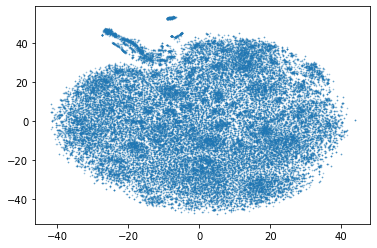

In [567]:
#2 dimensional t-SNE plot of hyperdimensional movie vectors
plt.scatter(df['x'], df['y'], s=0.4, alpha=0.4)

In [135]:
def tsnescatterplot(model, word, list_names):
    """ Plot vectors of a query word with list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 50), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 50 to 10 dimensions with PCA
    reduce = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduce)
    
    # Sets everything
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

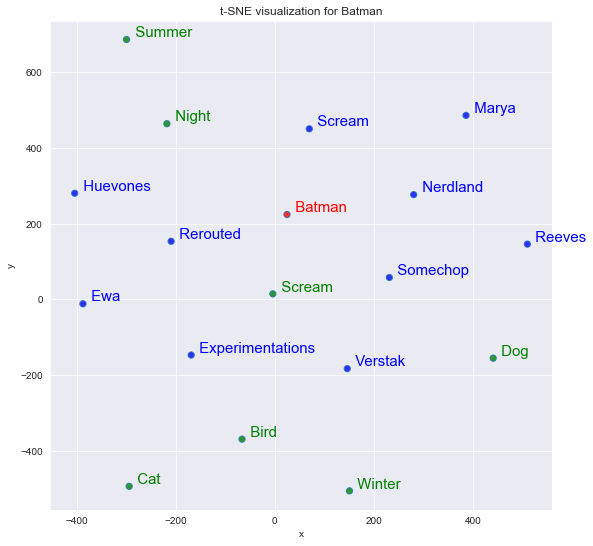

In [148]:
#Similarity graph - here we can input a movie/word and see list of similar words in blue from the model. The closer they are postioned to batman higher the similarity. 
#Words in green are user inputs (just a depiction) to show dissimilarity. To see this, we can input one similar word 'scream' in this example and see that even though in
#green because it's close to the movie we can see it's closer to our target word in the graph.

tsnescatterplot(model, 'batman', ['dog', 'bird', 'cat', 'winter', 'summer', 'night', 'scream'])


User interactions data to make recommendations for every user using history of watches; 
So we will make a function where we will input user data and user id and then based on top 5 movies they watched based on ratings, 
we will recommend 10 similar movies using doc2vec.

In [149]:
# Reading interaction data:
ratings = read_csv_from_gdrive(RATINGS_SMALL_URL)

In [153]:
movie_dataset=movies_metadata
ratings['movieId'] = ratings['movieId'].astype(str)
movie_dataset.rename(columns = {'id': 'movieId'}, inplace = True)

In [154]:
merged_dataset = pd.merge(ratings, movie_dataset, how='inner', on='movieId')
merged_dataset = merged_dataset.sort_values("timestamp",ascending=False)

In [155]:
merged_dataset.drop_duplicates(["userId", "movieId"], inplace=True)

This function will create a list of movies by entering the userid and this list should go in the recomm function and we can predict the movies based on user history.

In [156]:
def user_recommendation(userdata:pd.DataFrame,
                        userid:int,
                        model:gensim.models.doc2vec.Doc2Vec,
                        movies_inv_mapper:dict):
    
    refined_dataset = userdata.sort_values("rating", ascending=False)                    
    refined_dataset['rank'] = refined_dataset.groupby(by=['userId'], as_index=False)['rating'].rank(method='first')
    refined_dataset = refined_dataset[refined_dataset['rank'] <= 5] 

    movie_list = list(refined_dataset[refined_dataset['userId'] == userid]['original_title'].str.lower())
    
    output = get_recommendations(model,
                                 movies_inv_mapper,
                                 movie_list)
    return output

In [157]:
# So lets recommennd 10 movies each for user id 46 based on watch history (top 5):
user_recommendation(merged_dataset, 46 , model, movies_inv_mapper)

,model_index,model_score,title_name
0,1783,1.000000,a perfect murder
1,15351,0.959958,"east side, west side"
2,10722,0.946285,a woman's face
3,7080,0.945685,mesmerized
4,11620,0.942230,mad love
5,20225,0.941247,painted lady
6,38086,0.940952,dotkniecie reki
7,15242,0.940627,killers
8,3841,0.939591,NaN
9,6034,0.938945,a countess from hong kong


*******END******